<a href="https://colab.research.google.com/github/dhsilva2912/MIT_ComputerVision/blob/main/BigGAN_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BigGAN exploration

Note: this code is modified from a [tutorial](https://colab.research.google.com/drive/1WRcCnYX_fjN3hp5-DXhGquXHs44hgVV6) by [Lucy Chai](http://people.csail.mit.edu/lrchai/).

## Fundamentals:

We will use [BigGAN](https://arxiv.org/abs/1809.11096) as our image generator. Recall that GANs are trained using a pair of models -- a generator G and a discriminator D -- using an adversarial loss. G learns a mapping from a random noise vector, z, to an image. D is a classifier that tries to distinguish whether an image is real, or generated by G.  In addition to the noise vector z, the BigGAN generator takes in a class vector y, which corresponds to the 1000 ImageNet classes. A mapping of class identifiers to class labels can be found [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

GANs, and BigGAN in particular, take a lot of time and compute to train properly. For our purposes, we just want to learn within BigGAN latent space. Therefore, we will use a pretrained model and treat those weights as fixed. The following section sets up the prerequisites to build the BigGAN generator and load pretrained weights.

In [1]:
# install pytorch biggan
!pip install pytorch-pretrained-biggan

     |████████████████████████████████| 133kB 19.5MB/s 
     |████████████████████████████████| 7.2MB 26.2MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
ERROR: botocore 1.19.61 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


##  Imports and Model

Here we will set and load the pretrained generator weights.


In [2]:
import torch
from pytorch_pretrained_biggan import (
    BigGAN, 
    one_hot_from_int, 
    truncated_noise_sample)
import time
import torchvision.utils as vutils
import torch.optim as optim
import torch.nn as nn
from PIL import Image
import numpy as np
import IPython.display
import cv2

In [3]:
# check that a gpu is available
torch.cuda.device_count()

1

In [4]:
G = BigGAN.from_pretrained('biggan-deep-256')

100%|██████████| 715/715 [00:00<00:00, 201649.23B/s]


##  Generate Random Samples

Before we move on, let's generate some random samples from G and see what they look like, as a sanity check. Because we are using pre-trained weights, these samples should look reasonable already.

In [5]:
# following the example at:
# https://github.com/huggingface/pytorch-pretrained-BigGAN

# Prepare a input
truncation = 0.4
class_vector = one_hot_from_int(207, batch_size=4) # 207 is the golden retriever class; try changing this, there are 1000 classes
noise_vector = truncated_noise_sample(truncation=truncation,
                                      batch_size=4, seed=1)

# All in tensors
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')
G.to('cuda')

# Generate an image
with torch.no_grad():
    output = G(noise_vector, class_vector, truncation)

image_grid = vutils.make_grid(
    output,
    nrow=4,
    normalize=True,
)

In [6]:
image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
image_grid_np = np.uint8(image_grid_np)
print("Image Grid Shape: {}".format(np.shape(image_grid_np)))
print("Max pixel value: {}".format(np.max(image_grid_np)))
print("Min pixel value: {}".format(np.min(image_grid_np)))

Image Grid Shape: (260, 1034, 3)
Max pixel value: 254
Min pixel value: 0


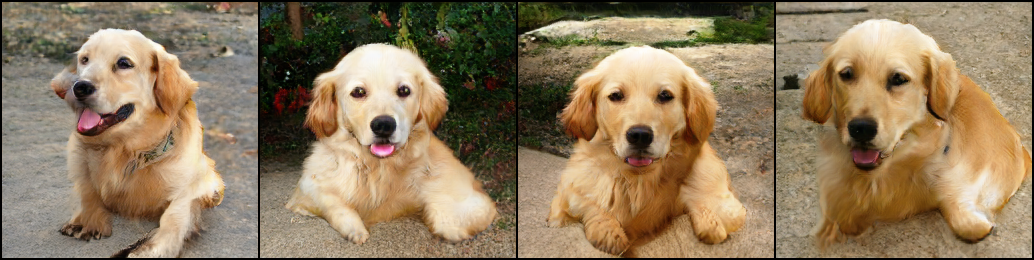

In [7]:
IPython.display.display(Image.fromarray(image_grid_np))

In [ ]:
# To do:
# -- try to output more than 4 images
# -- try to output other image categories (change the class vector)
# -- play with the truncation parameter and see what happens

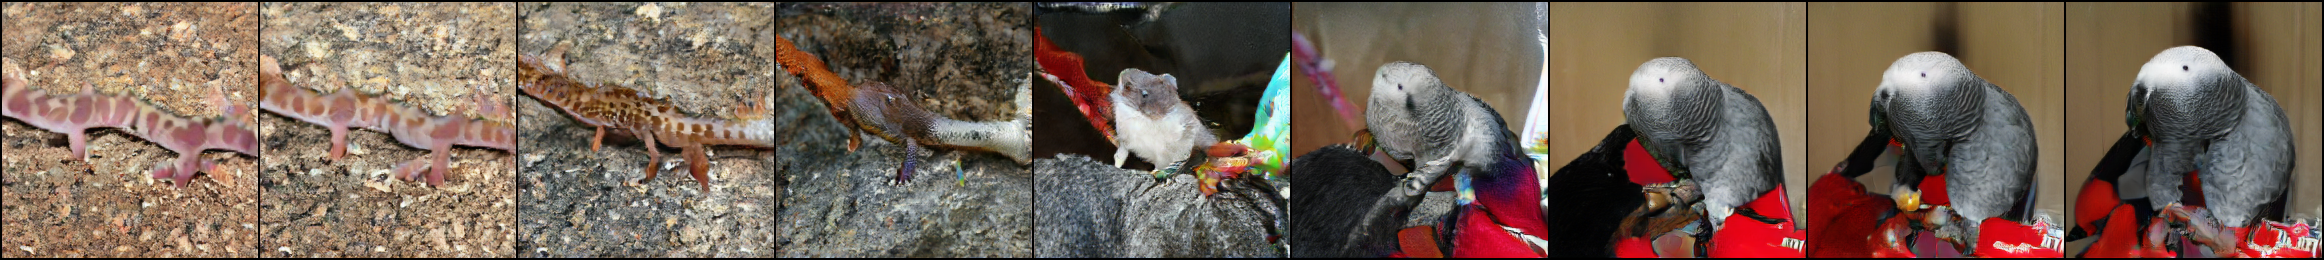

In [13]:
# Interpolate between BigGAN samples

num_interps = 9 #@param {type:"slider", min:2, max:10, step:1}
truncation = 0.06 #@param {type:"slider", min:0.02, max:1, step:0.02}
class_A = 38 #@param {type:"slider", min:0, max:999, step:1}
class_B = 87 #@param {type:"slider", min:0, max:999, step:1}

class_vector_A = one_hot_from_int(class_A, batch_size=1)
class_vector_B = one_hot_from_int(class_B, batch_size=1)

noise_vector_A = truncated_noise_sample(truncation=truncation,
                                        batch_size=1, seed=1)
noise_vector_B = truncated_noise_sample(truncation=truncation,
                                        batch_size=1, seed=1)

def interpolate(A, B, num_interps):
  if A.shape != B.shape:
    raise ValueError('A and B must have the same shape to interpolate.')
  alphas = np.linspace(0, 1, num_interps)
  interps = None
  for a in alphas:
    interp = (1-a)*A + a*B
    if interps is None:
      interps = interp
    else:
      interps = torch.cat((interps, interp))
  return interps

# All in tensors
noise_vector_A = torch.from_numpy(noise_vector_A)
noise_vector_B = torch.from_numpy(noise_vector_B)
class_vector_A = torch.from_numpy(class_vector_A)
class_vector_B = torch.from_numpy(class_vector_B)

# If you have a GPU, put everything on cuda
noise_vector_A = noise_vector_A.to('cuda')
noise_vector_B = noise_vector_B.to('cuda')
class_vector_A = class_vector_A.to('cuda')
class_vector_B = class_vector_B.to('cuda')
G.to('cuda')

noise_vector_interp = interpolate(noise_vector_A, noise_vector_B, num_interps)
class_vector_interp = interpolate(class_vector_A, class_vector_B, num_interps)

# Generate an image
with torch.no_grad():
    output = G(noise_vector_interp, class_vector_interp, truncation)

image_grid = vutils.make_grid(
    output,
    nrow=len(noise_vector_interp),
    normalize=True,
)

image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
image_grid_np = np.uint8(image_grid_np)

IPython.display.display(Image.fromarray(image_grid_np))

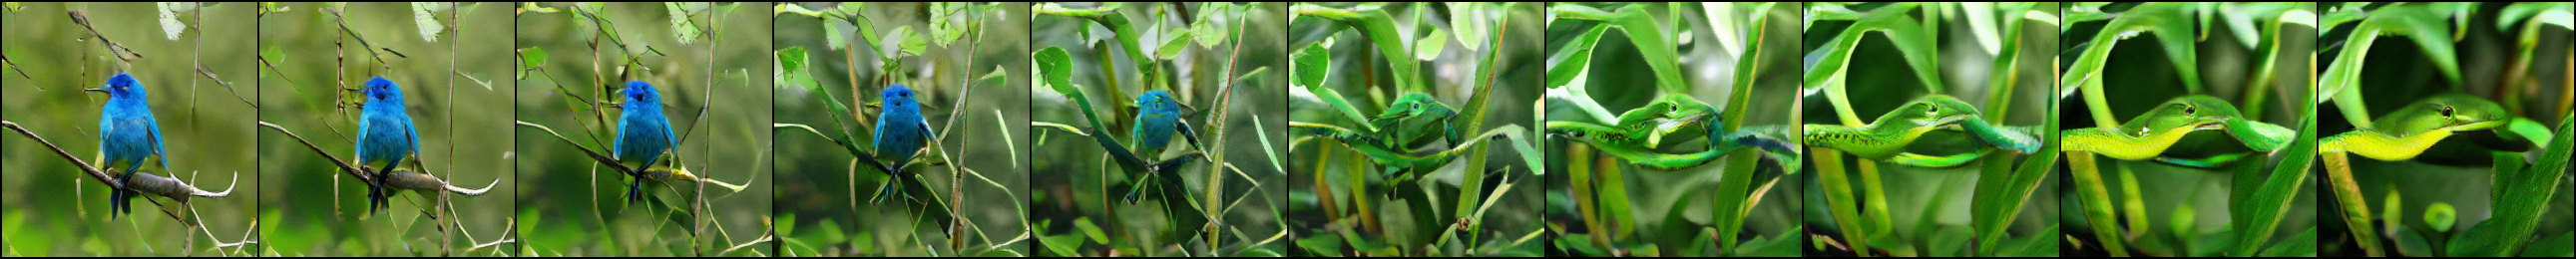

In [15]:
# that was linear interpolation, what about spherical?

# define spherical interpolation, i.e. shortest path on the surface of a sphere, a.k.a. "slerp"
def slerp(A, B, num_interps):
  # see https://en.wikipedia.org/wiki/Slerp
  alphas = np.linspace(-1.5, 2.5, num_interps) # each unit step tends to be a 90 degree rotation in high-D space, so this is ~360 degrees
  omega = np.zeros((A.shape[0],1))
  for i in range(A.shape[0]):
      tmp = np.dot(A[i],B[i])/(np.linalg.norm(A[i])*np.linalg.norm(B[i]))
      omega[i] = np.arccos(np.clip(tmp,0.0,1.0))+1e-9
  
  interps = None
  for a in alphas:
    interp = (np.sin((1-a)*omega)/np.sin(omega))*A + (np.sin(a*omega)/np.sin(omega))*B
    if interps is None:
      interps = interp
    else:
      interps = torch.cat((interps, interp))
  return interps

num_interps = 10 #@param {type:"slider", min:2, max:10, step:1}
truncation = 0.2 #@param {type:"slider", min:0.02, max:1, step:0.02}
class_A = 14 #@param {type:"slider", min:0, max:999, step:1}
class_B = 55 #@param {type:"slider", min:0, max:999, step:1}

noise_seed_A = 3 # right facing
noise_seed_B = 31 # left facing

class_vector_A = one_hot_from_int(class_A, batch_size=1)
class_vector_B = one_hot_from_int(class_B, batch_size=1)

noise_vector_A = truncated_noise_sample(truncation=truncation,
                                        batch_size=1, seed=noise_seed_A)
noise_vector_B = truncated_noise_sample(truncation=truncation,
                                        batch_size=1, seed=noise_seed_B)

# All in tensors
noise_vector_A = torch.from_numpy(noise_vector_A)
noise_vector_B = torch.from_numpy(noise_vector_B)
class_vector_A = torch.from_numpy(class_vector_A)
class_vector_B = torch.from_numpy(class_vector_B)

# If you have a GPU, put everything on cuda
noise_vector_A = noise_vector_A.to('cuda')
noise_vector_B = noise_vector_B.to('cuda')
class_vector_A = class_vector_A.to('cuda')
class_vector_B = class_vector_B.to('cuda')
G.to('cuda')

noise_vector_interp = interpolate(noise_vector_A, noise_vector_B, num_interps)
class_vector_interp = interpolate(class_vector_A, class_vector_B, num_interps)

# Generate an image
with torch.no_grad():
    output = G(noise_vector_interp, class_vector_interp, truncation)

image_grid = vutils.make_grid(
    output,
    nrow=len(noise_vector_interp),
    normalize=True,
)

image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
image_grid_np = np.uint8(image_grid_np)

IPython.display.display(Image.fromarray(image_grid_np))

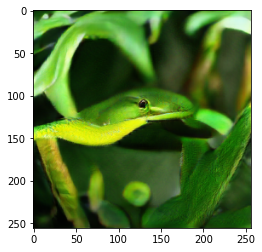

In [16]:
# play video
# adapted from: https://stackoverflow.com/questions/51785450/displaying-a-sequence-of-images-in-jupyter-notebook?noredirect=1&lq=1
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def showVideo(ims):
    numFrames = ims.shape[0]
    fig = plt.figure()
    im = plt.imshow(ims[0,:,:])

    def update(i):
        img = ims[i,:,:]
        im.set_data(img)
        return im

    ani = animation.FuncAnimation(fig, update, frames=numFrames, repeat=False)  
    display(HTML(ani.to_html5_video()))

showVideo(np.transpose(((output+1)/2).detach().cpu().numpy(), (0,2,3,1)))

## Additional Resources


Here are some additional resources that you can check out!
- [GAN Steerability](https://github.com/ali-design/gan_steerability) full code repository (in tensorflow)
- [BigGAN in tensorflow](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/biggan_generation_with_tf_hub.ipynb#scrollTo=Cd1dhL4Ykbm7) colab notebook
- [BigGAN in pytorch](https://github.com/ajbrock/BigGAN-PyTorch) code repository
- [Ganalyze](http://ganalyze.csail.mit.edu/) - a related paper that transforms cognitive properties